In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Progress bar
from tqdm import tqdm

#Image pre-processing
from PIL import Image

#For reading CSV and for math
import numpy as np
import pandas as pd

#Visualize some data
import matplotlib.pyplot as plt

#Check our work directory
import os
import shutil

import random

import warnings
warnings.filterwarnings("ignore")

# Raw dataset analysis

In [ ]:
blur_path = r'dataset\blur'
sharp_path = r'dataset\not_blur'

In [ ]:
#Analyzing resolutions of dataset

resolutions_blur = []
for filename in tqdm(os.listdir(blur_path)):
    file_path = os.path.join(blur_path, filename)
    im = Image.open(file_path)
    width, size = im.size
    resolutions_blur.append((width, size))

resolutions_sharp = []
for filename in tqdm(os.listdir(sharp_path)):
    file_path = os.path.join(sharp_path, filename)
    im = Image.open(file_path)
    width, size = im.size
    resolutions_sharp.append((width, size))

resolutions_blur.sort()
resolutions_sharp.sort()
#print(resolutions)

In [ ]:
# Get some plots

def get_values(list):
    values_0, values_1 = [0] * 4, [0] * 4
    for i in list:
        if i[0] > 1000:
            values_0[3] += 1
        elif i[0] > 600:
            values_0[2] += 1
        elif i[0] > 200:
            values_0[1] += 1
        else:
            values_0[0] += 1
        
        if i[1] > 1000:
            values_1[0] += 1
        elif i[1] > 600:
            values_1[1] += 1
        elif i[1] > 200:
            values_1[2] += 1
        else:
            values_1[3] += 1

    return values_0, values_1



categories = ['<200', '200-600', '600-1000', '>1000']

values_X_sharp, values_Y_sharp = get_values(resolutions_sharp)
values_X_blur, values_Y_blur = get_values(resolutions_blur)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.bar(categories, values_X_sharp)
ax1.set_title('X-axis resolution (Sharp)')
ax1.set_xticklabels(categories)

ax2.bar(categories, values_Y_sharp)
ax2.set_title('Y-axis resolution (Sharp)')
ax2.set_xticklabels(categories)

ax3.bar(categories, values_X_blur)
ax3.set_title('X-axis resolution (Blur)')
ax3.set_xticklabels(categories)

ax4.bar(categories, values_Y_blur)
ax4.set_title('Y-axis resolution (Blur)')
ax4.set_xticklabels(categories)


plt.show()

# Data prepreprocessing

In [ ]:
def split_files_by_classes(file_list, path):
    # Splitting files into classes / Разбиваем файлы по классам
    class_dict = {'200-': [], '200-600': [], '600-1000': [], '1000+': []}
    for file_name in tqdm(file_list):
        file_path = os.path.join(path, file_name)
        with Image.open(file_path) as img:
            width, height = img.size
            if width < 200:
                class_dict['200-'].append(file_name)
            elif width < 600:
                class_dict['200-600'].append(file_name)
            elif width < 1000:
                class_dict['600-1000'].append(file_name)
            else:
                class_dict['1000+'].append(file_name)
    return class_dict



blur_photos = split_files_by_classes(os.listdir(blur_path), blur_path)
not_blur_photos = split_files_by_classes(os.listdir(sharp_path), sharp_path)

In [ ]:
# FIXME: Костыль: создаёт папки внутри blur и not_blur. хз как фиксить 

def create_folders_and_split_files(class_dict, path, label:str, train_val_split = 0.8):
    for class_name, file_list in class_dict.items():
        class_path = os.path.join(path, class_name)
        os.makedirs(os.path.join(class_path, 'train', label), exist_ok=True)
        os.makedirs(os.path.join(class_path, 'val', label), exist_ok=True)

        random.shuffle(file_list)
        split_index = int(len(file_list) * train_val_split)
        train_files = file_list[:split_index]
        test_files = file_list[split_index:]

        for file_name in train_files:
            src_path = os.path.join(path, file_name)
            dst_path = os.path.join(class_path, 'train', label, file_name)
            shutil.copy(src_path, dst_path)
        for file_name in test_files:
            src_path = os.path.join(path, file_name)
            dst_path = os.path.join(class_path, 'val', label, file_name)
            shutil.copy(src_path, dst_path)

create_folders_and_split_files(blur_photos, blur_path, "blur")
create_folders_and_split_files(not_blur_photos, sharp_path, "not_blur")

# Constants

In [2]:
LR = 0.001
BATCH_SIZE = 8
EPOCHS = 15

# Create data loader

In [3]:
path_to_data = r"dataset\600-1000"

In [39]:
resolutions = []
for root, _, files in os.walk(path_to_data):
    for file in tqdm(files):
        file_path = os.path.join(root, file)
        with Image.open(file_path) as img:
            width, height = img.size
            resolutions.append((width, height))

sorted_list = sorted(resolutions, key=lambda x: (x[0], x[1]))

sorted_list_x = [x[0] for x in sorted_list]
sorted_list_y = [x[1] for x in sorted_list]

print("Минимальный ширина картинки:", sorted_list_x[0])
print("Минимальный высота картинки:", sorted_list_y[0])

print("Средняя ширина картинки: ", np.mean(sorted_list_x))
print("Средняя высота картинки: ", np.mean(sorted_list_y))


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 4804/4804 [00:00<00:00, 9531.75it/s]
0it [00:00, ?it/s]
100%|██████████| 1202/1202 [00:00<00:00, 9616.09it/s]

Минимальный ширина картинки: 600
Минимальный высота картинки: 200
Средняя ширина картинки:  688.2907092907093
Средняя высота картинки:  470.47735597735596


In [4]:
# Возьмем размерность 64х64 потому что 78 и 58 не кратно 32 (в архитектуре модели кол-во пикселей будет уменьшаться вдвое 5 раз)
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.41),
     transforms.RandomVerticalFlip(p=0.79),
     transforms.Resize((640, 640)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
train_folder = datasets.ImageFolder(root=os.path.join(path_to_data, "train"), transform=transform)
val_folder = datasets.ImageFolder(root=os.path.join(path_to_data, "val"),transform=transform)

In [6]:
train_folder.classes

['blur', 'not_blur']

In [7]:
train_loader = DataLoader(train_folder,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(val_folder,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

# Model section

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # input [3, 640, 640]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),  # [64, 640, 640]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [64, 320, 320]

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1), # [128, 320, 320]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [128, 160, 160]

            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1), # [256, 160, 160]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [256, 80, 80]

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1), # [512, 80, 80]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),       # [512, 40, 40]
            
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1), # [512, 40, 40]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),       # [512, 20, 20]
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features = 512*20*20, out_features = 1024),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 128), 
            nn.ReLU(), 
            nn.Linear(in_features = 128, out_features = 2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
net = Net()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('Using: ',device)
net.to(device)

Using:  cuda


Net(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

In [11]:
# Загружаем модель которую будем предобучать
try:
    if device.type == "cpu":
        print('Загрузили на cpu')
        net.load_state_dict(torch.load("2 model for retraining.pt", map_location=torch.device('cpu')))
    else:
        print('Загрузили на cuda')
        net.load_state_dict(torch.load("2 model for retraining.pt"))
except FileNotFoundError:
    print("Saved model file not found.")
except:
    print("Error loading saved model.")

Загрузили на cuda


In [12]:
# Заморажеваем все веса кроме слоя FC
for param in net.parameters():
    param.requires_grad = False

for param in net.fc.parameters():
    param.requires_grad = True

In [13]:
# Проверяем будет ли работать сеть на случайном изображении 64х64
# Создаем случайное изображение размером 64x64
input_tensor = torch.randn((1, 3, 640, 640)).to(device)

# Прогоняем изображение через модель
output_tensor = net(input_tensor) # explicitly move the input tensor to the same device as the model
#Если ошибок нет, то все хорошо

# Training and evaluating section

In [17]:
# Cross Entropy Loss  
error = nn.CrossEntropyLoss()


#Adam optimizer
optimizer = optim.Adam(net.parameters(), lr = LR)

In [18]:
from sklearn.metrics import roc_auc_score

# For plotting
train_losses_by_epochs = []
train_metric_by_epochs = []
val_losses_by_epochs = []
val_metric_by_epochs = []

# For saving the best model weights
best_metric = 0.0 
best_model_path = 'rt_best_model_weights.pt'

# Training loop
for epoch in range(EPOCHS):
    # Initialize metrics and losses for the epoch
    train_metric = []
    val_metric = []
    train_loss = []
    val_loss = []
    
    # Train the model on the training set
    loop = tqdm(train_loader, leave=True)
    net.train()
    for batch in loop:
        loop.set_description(f"Epoch {epoch+1} / {EPOCHS}")

        optimizer.zero_grad()
        inputs, labels = batch[0].to(device), batch[1].to(device)
        y_pred = net(inputs)

        loss = error(y_pred,labels.long())
        loss.backward()
        
        optimizer.step()

        y_true = labels.cpu().numpy()
        y_pred = np.argmax(y_pred.cpu().data.numpy(), axis=1)
        try:
            auc = roc_auc_score(y_true, y_pred)
            train_metric.append(auc)
        except ValueError:
            pass

        train_loss.append(loss.item())
        loop.set_postfix(loss=np.mean(train_loss), AUC_ROC=np.mean(train_metric))
    
    # Save training metrics for the epoch
    train_losses_by_epochs.append(np.mean(train_loss))
    train_metric_by_epochs.append(np.mean(train_metric))

    # Evaluate the model on the validation set
    net.eval()
    with torch.no_grad():
        loop = tqdm(val_loader, leave=True)
        for batch in loop:
            loop.set_description(f"Validation {epoch+1}")

            inputs, labels = batch[0].to(device), batch[1].to(device)
            val_pred = net(inputs)

            batch_loss = error(val_pred,labels.long())

            val_true = labels.cpu().numpy()
            val_pred = np.argmax(val_pred.cpu().data.numpy(), axis=1)
            try:
                auc = roc_auc_score(val_true, val_pred)
                val_metric.append(auc)
            except ValueError:
                pass

            val_loss.append(batch_loss.item())
            loop.set_postfix(loss=np.mean(val_loss), AUC_ROC=np.mean(val_metric))

        # Save validation metrics for the epoch
        val_losses_by_epochs.append(np.mean(val_loss))
        val_metric_by_epochs.append(np.mean(val_metric))

    # Save the model weights if the validation AUC_ROC is improved
    if np.mean(val_metric) > best_metric:
        best_metric = np.mean(val_metric)
        torch.save(net.state_dict(), best_model_path)

print(f"Best model weights have {best_metric:.3f} AUC_ROC val and are saved under the name {best_model_path}")


Validation 15: 100%|██████████| 301/301 [01:27<00:00,  3.45it/s, AUC_ROC=0.909, loss=0.213]

Best model weights have 0.9226428571428571 AUC_ROC and are saved under the name rt_best_model_weights.pt


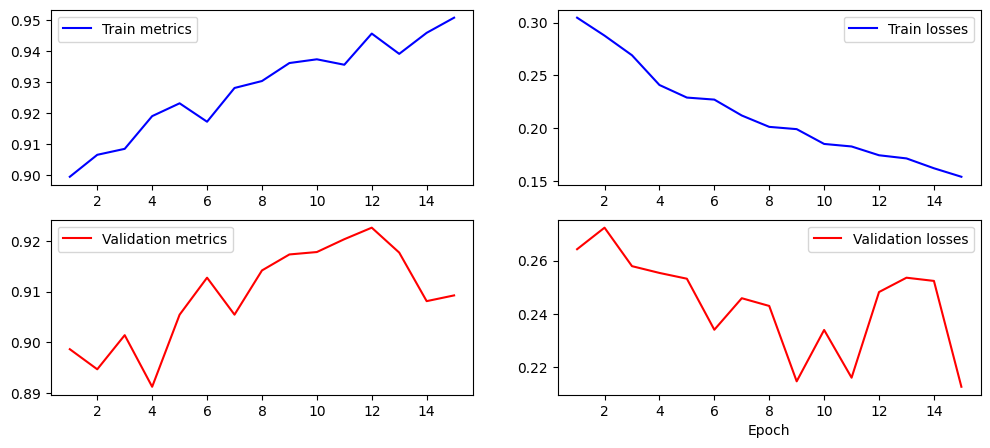

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5))

ax1.plot(range(1, len(train_metric_by_epochs) + 1), train_metric_by_epochs, color='blue', label='Train metrics')
ax1.legend()
ax2.plot(range(1, len(train_losses_by_epochs) + 1), train_losses_by_epochs, color='blue', label='Train losses')
ax2.legend()
ax3.plot(range(1, len(val_metric_by_epochs) + 1), val_metric_by_epochs, color='red', label='Validation metrics')
ax3.legend()
ax4.plot(range(1, len(val_losses_by_epochs) + 1), val_losses_by_epochs, color='red', label='Validation losses')
ax4.legend()

plt.xlabel('Epoch')

plt.show()

In [9]:
net.load_state_dict(torch.load("rt_best_model_weights.pt"))

<All keys matched successfully>

In [25]:
from torch.autograd import Variable
from PIL import Image

def predict_image(image_path, model, device):
    image = Image.open(image_path)

    transform = transforms.Compose(
    [transforms.Resize((640, 640)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze(0)

    if torch.cuda.is_available() and device == "cuda":
        image_tensor.cuda()
        input = Variable(image_tensor.cuda(), requires_grad=True) #torch.Tensor(image_tensor.cuda(), requires_grad=True)
    else:
        input = Variable(image_tensor.cuda(), requires_grad=True) #torch.Tensor(image_tensor.cuda(), requires_grad=True)
    output = model(input)
    #label = output.data.cpu().numpy()
    label = nn.functional.softmax(output.data.cpu())
    label = label.numpy()
    
    return label[0][0].round(2)
    #plt.imshow(image)


In [26]:
predict_image(r"D:\Рабочий стол\Проги\ML\Blur detection\dataset\200-\val\not_blur\02998(1).jpg", net, device)

[-0.9376012   0.14943492]
[[0.2521768 0.7478232]]


0.25